In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime,timedelta
import pandas as pd
import scipy

import niskine
import mplniw.plot as pl
import gvpy as gv
import mplniw.sigp as sp
import mplniw.utils as ut

In [16]:
mooring=1
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=mooring)
root_dir = '/Users/zcasparcohen/codes/NIW/'
figdir = '/Users/zcasparcohen/Documents/NISKINE/Figures/'

In [17]:

# Wind
wind_work = xr.open_dataset(root_dir+'data/ni_wind_work_niskine_m1.nc').rename({'__xarray_dataarray_variable__':'wind_work'})
wind_stress = xr.open_dataset(root_dir+'data/wind_work/wind_stress_niskine_m1.nc')

#Velocity time series
ds = xr.open_dataset(root_dir+'data/NI02_M%s.nc'%mooring)
gridded=xr.open_dataset(root_dir+'data/M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
wkb = niskine.clim.get_wkb_factors(gridded)
ds['bpuz'] = wkb*ds['u_filtered'].differentiate('z')
ds['bpvz'] = wkb*ds['v_filtered'].differentiate('z')

ds['uz'] = ds['u'].differentiate('z')
ds['vz'] = ds['v'].differentiate('z')

#Vorticity
vort = xr.open_dataset(root_dir+'data/vorticity_moorings.nc')
vort_alt = xr.open_dataset(root_dir+'data/vorticity_alt.nc')

#N
N2 = xr.open_dataset(root_dir+'data/N_daily.nc').rename({'__xarray_dataarray_variable__':'N2'})

In [18]:
ds['KE_mld'] = ds.ni_ke_wkb.where(ds.z<ds.mld+100).mean('z')
ds['wind_work_diff'] = np.abs(wind_work['wind_work']).cumsum().differentiate('time')
ds['bpUVz'] = ds.bpuz + 1j* ds.bpvz
ds['UVz'] = ds.uz + 1j* ds.vz

In [19]:
x = ds.UVz.real
y = ds.UVz.imag
depthrange  = [50,1400]
nfft = ds.z.sel(z=slice(depthrange[0],depthrange[1])).size
nfft_t = 30*24*6
fs = ds.z.diff('z')[0].values
fnom = np.linspace(fs/nfft,fs/2,nfft//2)

In [20]:
_x = x.sel(z=slice(depthrange[0],depthrange[1])).interpolate_na('time').dropna('time')
_y = y.sel(z=slice(depthrange[0],depthrange[1])).interpolate_na('time').dropna('time')

In [21]:
wind=scipy.signal.windows.hann(nfft,sym=False);
W1=2/np.linalg.norm(wind)**2 ;

In [22]:
_  =ds.bpUVz.sel(z=slice(depthrange[0],depthrange[1])).interpolate_na('time',method='linear').dropna('time').values

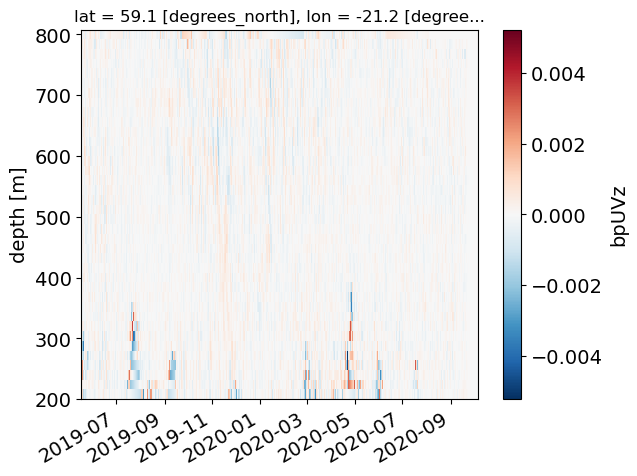

In [34]:
ds.bpUVz.sel(z=slice(depthrange[0],depthrange[1])).interpolate_na('time',method='linear').real.plot()

In [23]:
for i in range(_.shape[-1]):
    _[:,i] = _[:,i] * wind

Gxx = scipy.fft.fft(scipy.signal.detrend(_.real),n=nfft,axis=0) #*wind
Gyy = scipy.fft.fft(scipy.signal.detrend(_.imag),n=nfft,axis=0) #*wind
Gxy = scipy.fft.fft(scipy.signal.detrend(_),n=nfft,axis=0) #*wind
Cxy = np.empty_like(Gxx)
Qxy = np.empty_like(Gxx)

CW = np.empty((nfft//2,Gxx.shape[-1]))
CCW = np.empty((nfft//2,Gxx.shape[-1]))
GXX = np.empty((nfft//2,Gxx.shape[-1]))
GYY = np.empty((nfft//2,Gxx.shape[-1]))
GXY = np.empty((nfft//2,Gxx.shape[-1]))

for i in range(Gxx.shape[-1]):
    Cxy[:,i] = np.real(Gxx[:,i])*np.real(Gyy[:,i])+np.imag(Gxx[:,i])*np.imag(Gyy[:,i]);
    Qxy[:,i] = np.real(Gxx[:,i])*np.imag(Gyy[:,i])-np.imag(Gxx[:,i])*np.real(Gyy[:,i]);
    Gxx[:,i] = Gxx[:,i] * np.conjugate(Gxx[:,i])
    Gyy[:,i] = Gyy[:,i] * np.conjugate(Gyy[:,i])
    Gxy[:,i] = Gxy[:,i] * np.conjugate(Gxy[:,i])
    #print(Gxx.shape)
    Gxx[:,i] =W1*Gxx[:,i]/nfft/fs;
    Gyy[:,i] =W1*Gyy[:,i]/nfft/fs;
    Gxy[:,i] =W1*Gxy[:,i]/nfft/fs;
    Cxy[:,i] =2*W1*Cxy[:,i]/nfft/fs;
    Qxy[:,i] =2*W1*Qxy[:,i]/nfft/fs;
    Gxx[0:nfft//2,i] = Gxx[1:nfft//2+1,i];
    Gyy[0:nfft//2,i] = Gyy[1:nfft//2+1,i];
    Gxy[0:nfft//2,i] = Gxy[1:nfft//2+1,i];
    Cxy[0:nfft//2,i] = Cxy[1:nfft//2+1,i];
    Qxy[0:nfft//2,i] = Qxy[1:nfft//2+1,i];
    GXX[:,i]=Gxx[:nfft//2,i];
    GYY[:,i]=Gyy[:nfft//2,i]
    GXY[:,i]=np.sqrt(Cxy[:nfft//2,i]**2+Qxy[:nfft//2,i]**2);
    CW[:,i]=0.5*(Gxx[:nfft//2,i]+Gyy[:nfft//2,i]+Qxy[:nfft//2,i]);
    CCW[:,i]=0.5*(Gxx[:nfft//2,i]+Gyy[:nfft//2,i]-Qxy[:nfft//2,i]);

/var/folders/vl/tj6snrv54zd212pkvk5g_l140000gn/T/ipykernel_2154/3321494293.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  GXX[:,i]=Gxx[:nfft//2,i];
/var/folders/vl/tj6snrv54zd212pkvk5g_l140000gn/T/ipykernel_2154/3321494293.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  GYY[:,i]=Gyy[:nfft//2,i]
/var/folders/vl/tj6snrv54zd212pkvk5g_l140000gn/T/ipykernel_2154/3321494293.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  GXY[:,i]=np.sqrt(Cxy[:nfft//2,i]**2+Qxy[:nfft//2,i]**2);
/var/folders/vl/tj6snrv54zd212pkvk5g_l140000gn/T/ipykernel_2154/3321494293.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  CW[:,i]=0.5*(Gxx[:nfft//2,i]+Gyy[:nfft//2,i]+Qxy[:nfft//2,i]);
/var/folders/vl/tj6snrv54zd212pkvk5g_l140000gn/T/ipykernel_2154/3321494293.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  CCW[:,i]=0.5*(Gxx[:nfft//2,i]+Gyy[

In [24]:
k = np.linspace(fs/nfft,fs/2,nfft//2)
time = ds.bpUVz.sel(z=slice(depthrange[0],depthrange[1])).interpolate_na('time').dropna('time').time.values
spectra = xr.Dataset({'psddown':(['k','time'],CW),'psdup':(['k','time'],CCW)},coords={'k':(['k'],k/2/np.pi),'time':(['time'],time)})

In [25]:
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

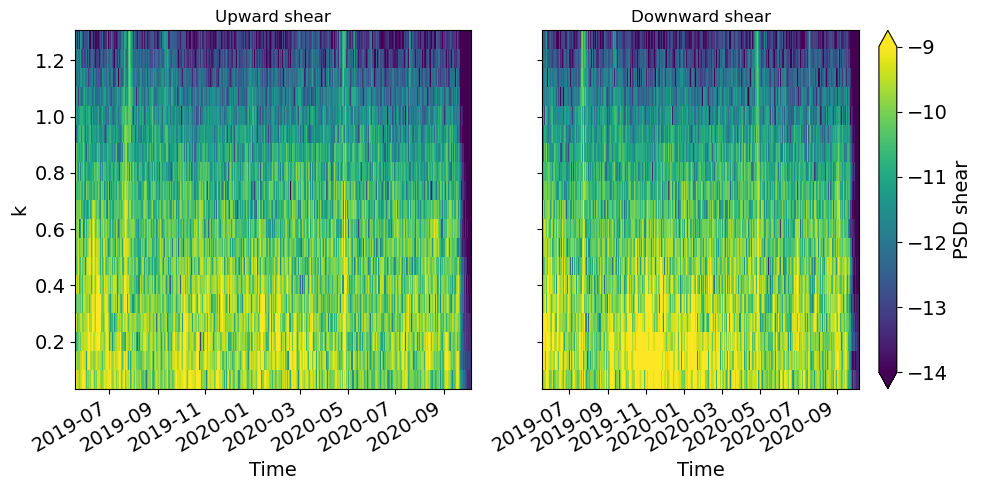

In [38]:
fig,axs = plt.subplots(1,2,figsize=(10,5),sharey=True)
np.log10(spectra.psdup).plot(ax=axs[0],vmax=-9, vmin=-14,add_colorbar=False)
np.log10(spectra.psddown).plot(ax=axs[1],vmax=-9, vmin=-14,cbar_kwargs={'label':'PSD shear'})
axs[1].set_ylabel('')
axs[1].set_xlabel('Time');axs[0].set_xlabel('Time')
axs[1].set_title('Downward shear');axs[0].set_title('Upward shear')
fig.tight_layout()
fig.savefig('/Users/zcasparcohen/Documents/Figures_poster/Shearspectra2D_M%s.png'%mooring)

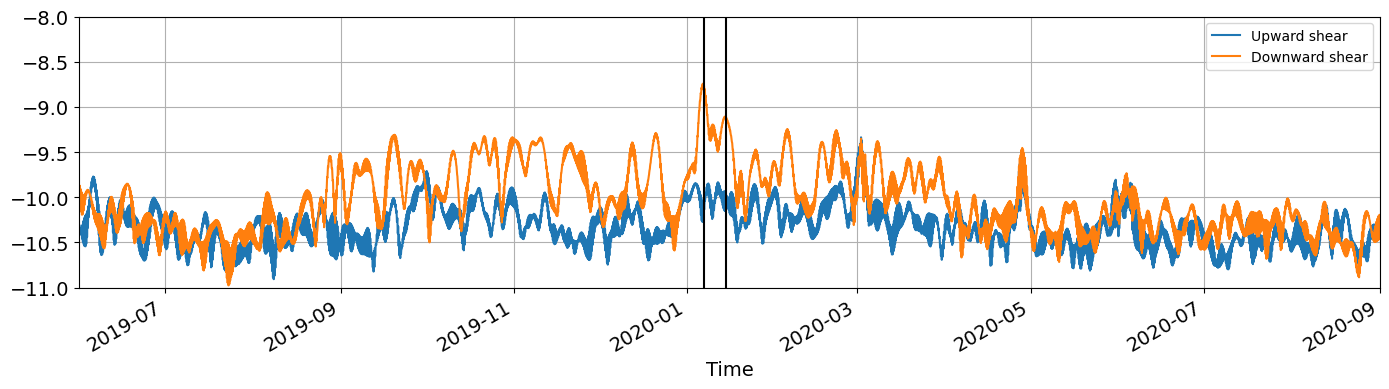

In [26]:
fig,ax = plt.subplots(figsize=(14,4))
np.log10(spectra.psdup.mean('k')).plot(ax=ax,ylim=(-11,-8),label='Upward shear')
np.log10(spectra.psddown.mean('k')).plot(ax=ax,ylim=(-11,-8),label='Downward shear')
ax.set_ylabel('')
ax.set_xlabel('Time')
ax.grid();ax.legend();ax.set_xlim(np.datetime64('2019-06-01'),np.datetime64('2020-09-01'))
ax.axvline(np.datetime64('2020-01-07'),c='k')
ax.axvline(np.datetime64('2020-01-14T20'),c='k')
fig.tight_layout()
#fig.savefig('/Users/zcasparcohen/Documents/Figures_poster/Shearspectra_M%s.pdf'%mooring)

In [5]:
"""Wavenumber and frequency spectrum S(K,f) estimation based on Beall(1982)"""
import numpy as np              # for linspace construction
import xarray as xr             # for data container construction


def beall(S, H, Dx, NK, chunks={'frequency': 1}, avg_dim='time',
          wavenumber_dim='wavenumber'):
    """Beall (1982) method of S(K,f) estimation from 2-point measurements

    Estimates the local wavenumber K and frequency f spectrum S(K,f)
    given the signal spectra and cross-spectrum and the distance between points

    Parameters
    ----------
    S : xarray.DataArray, (Nf,Nt) -> ('frequency', 'time')
        spectrum ansamble (i.e. spectrogram) S(f,t)
        should be average of spectra from both points
    H : array_like, (Nf,Nt)
        cross-spectrum ansamble (i.e. cross-spectrogram) H(f,t)
    Dx : float
        distance between the 2 measurement points
    NK : int
        requested number of points in local wavenumber dimension
    chunks : dict, optional
        argument to :py:meth:`xarray.DataArray.chunk` to distribute
        broadcasted K-f computation
    avg_dim : str, optional
        dimension over which to average over with mean. If None,
        no averaging is done and is left to the user.
    wavenumber_dim : str, optional
        name of the wavenumber dimension

    Returns
    -------
    S_K_f : xarray.DataArray, (NK, Nf) -> ('wavenumber', 'frequency')
        S(K, f) spectrum, wrapping dask array (uncomputed)
        if avg_dim is None, will also contain the 'time' dimension
    """
    K_max = np.pi / Dx  # Nyquist-like maximum unambiguously resolvable wavenumber
    K, DK = np.linspace(-K_max, K_max, NK, retstep=True)  # wavenumber range
    K = xr.DataArray(K, coords=[(wavenumber_dim, K)], name=wavenumber_dim)
    # local wavenumber approximated by central phase differentiation
    K_l = xr.apply_ufunc(np.angle, H) / Dx  # cross-phase over distance
    # chunk to a Dask array
    K_ld = K_l.chunk(chunks)
    in_bin = np.abs(K_ld - K) < DK/2
    S_K_f_toavg = S.where(in_bin)
    if avg_dim is None:
        return S_K_f_toavg
    else:
        S_K_f = S_K_f_toavg.mean(dim=avg_dim)
        return S_K_f


def beall_fft(sig1, sig2, Dx, NK, chunks={'frequency': 1}, avg_dim='time',
              wavenumber_dim='wavenumber', **spectral_kw):
    """Wrapper around :func:`beall` which uses FFT for spectra estimation

    Parameters
    ----------
    sig1 : xarray.DataArray, (Nt) -> ('time')
         1. signal to calculate spectra from
    sig2 : xarray.DataArray, (Nt) -> ('time')
         2. signal to calculate spectra from
    Dx : float
        distance between the 2 measurement points
    NK : int
        requested number of points in local wavenumber dimension
    chunks : dict, optional
        argument to :py:meth:`xarray.DataArray.chunk` to distribute
        broadcasted K-f computation
    avg_dim : str, optional
        dimension over which to average over with mean. If None,
        no averaging is done and is left to the user.
    wavenumber_dim : str, optional
        name of the wavenumber dimension
    spectral_kw : keyword arguments, optional
        extra keyword arguments will passed on to :py:func:`xarray_dsp.spectrogram`
        by default noverlap=0 to be consistent with Beall (1982)
        seglen=1/f_res may be of interest

    Returns
    -------
    ds : xarray.Dataset({S_K_f, S_f, S1, S2, H})
        S_K_f : S(K,f) wavenumber and frequency spectrum returned by :func:`beall`
        S_f : average S(f) spectrum used to calculate or normalize S(K,f)
        S1 : spectrogram of sig1
        S2 : spectrogram of sig2
        H : cross-spectrogram of sig1 and sig2
    """
    import xrscipy.signal as dsp
    spectral_kw = spectral_kw.copy()  # will modify copy
    spectral_kw.setdefault('noverlap', 0)  # to be consistent with Beall
    # ansamble spectra
    S1, S2 = (dsp.spectrogram(s, **spectral_kw) for s in (sig1, sig2))
    S = 0.5 * (S1 + S2)         # average ansamble spectra
    # cross spectra ansamble
    H = dsp.crossspectrogram(sig1, sig2, **spectral_kw)
    S_K_f = beall(S, H, Dx, NK, chunks, avg_dim, wavenumber_dim)
    ds = xr.Dataset({'S_K_f': S_K_f, 'S': S,
                         'S1': S1, 'S2': S2, 'H': H})
    return ds


def statistical_dispersion_relation(S_K_f, S_f, wavenumber_dim='wavenumber'):
    r"""Estimate the statistical dispersion relation


    Calculates the mean and standard deviation of the wavenumber with respect
    to the other dimensions as

    .. math::

        s(K, f) = S(K, f) / S(f)
        \bar{K} = \int s(K,f) \cdot K dK
        \mathrm{sd}(K) = \sqrt{\int s(K,f) \cdot (K - \bar{K})^2  dK}


    Parameters
    ----------
    S_K_f : xarray.DataArray
        estimated S(K, f; ...) wavenumber-frequency spectrum
        must contain *wavenumber_dim* dimension
        other dimensions (frequency, time if not fully averaged)
        must broadcast with *S_f*
    S_f : xarray.DataArray
        frequency spectrum
        must broadcast with *S_K_f*
    wavenumber_dim : str, optional
        name of the wavenumber dimension in *S_K_f*

    Returns
    -------
    ds : xarray.Dataset
        s_K_f : conditional spectrum
        K_mean : mean K
        K_std : std. deviation about K_mean
    """
    s_K_f = S_K_f / S_f  # conditional spectrum
    K = s_K_f.coords[wavenumber_dim]
    K_mean = (K * s_K_f).sum(dim=wavenumber_dim)
    K_std = np.sqrt( ( (K - K_mean)**2 * s_K_f ).sum(dim=wavenumber_dim) )
    ds = xr.Dataset({'s_K_f': s_K_f, 'K_mean': K_mean, 'K_std': K_std})
    return ds

In [30]:
#ds = xr.Dataset()
dt = 10/(60*24)
#ds.coords['time'], dt = np.linspace(0, 1, 2**18, retstep=True)
f_nyq = 0.5/dt   # Nyquist frequency
nf = (ds.sel(z=slice(0,1500)).z.size) #2**8
ds.coords['frequency'] = np.linspace(-f_nyq, f_nyq, nf)
ds.coords['k'] = (ds.frequency/f_nyq)**3
ds.coords['phase'] = ('frequency', np.random.normal(size=nf))
k_nyq = ds.k.max()  # Highest k we want to resolve
Dx = (2*np.pi / k_nyq) / 2  # Sampling 2*k_nyq
#ds['sig1'] = np.cos(2*np.pi*ds.time*ds.frequency).sum(dim='frequency')
#ds['sig2'] = np.cos(2*np.pi*ds.time*ds.frequency + Dx*ds.k + ds.phase).sum(dim='frequency')
#ds

In [32]:
ds.frequency
Dx

<xarray.DataArray 'k' ()>
array(3.14159265)
Coordinates:
    lat      float64 ...
    lon      float64 ...

In [66]:
ds['UVz'] = ds.bpuz.interpolate_na('time',method='linear') + 1j*ds.bpvz.interpolate_na('time',method='linear')

In [35]:
beall_ds = beall_fft(ds.UVz, ds.UVz, Dx, 
                             NK=nf,
                             nperseg=nf,  # set FFT window to same res
                             return_onesided=False,  # full f spectra
                            )
beall_ds

ModuleNotFoundError: No module named 'xrscipy'

In [37]:
import scipy


In [71]:
_ = scipy.fft.fft2(ds.UVz.sel(z=slice(50,1400)).dropna('time').values)
_

array([[  1.44177527 +8.49850888j,  -0.2809241  +1.06582093j,
        -12.56442328 +3.69111057j, ...,  11.35281525+12.9061458j ,
        -18.39618497 -4.02306416j,  12.4165218  -5.97836645j],
       [  5.16038918 +8.33452056j,  -2.02807957 -1.25010115j,
         -6.55530562 +5.78855577j, ...,  16.08425297 +6.12720755j,
        -17.83968615 +4.54088819j,   6.97519344-10.62923754j],
       [  7.51636509 +4.46850913j,  -3.74818811 -0.93574326j,
         -2.03621342 +2.943104j  , ...,  13.88092136 -1.04786408j,
        -11.16544514 +8.99932884j,   0.07759008 -9.1967977j ],
       ...,
       [ -0.31688815 +6.83302641j,  -7.99294564 +0.67704118j,
         -4.87233731 -7.02239287j, ...,  -2.14976843 +2.5958747j ,
         -2.26214403 -5.6231955j ,   5.94523158 +3.57972157j],
       [  0.3603736  +5.78670642j,  -5.93744101 +4.5682162j ,
        -10.78387765 -7.76614921j, ...,  -2.4473996  +8.17907213j,
         -5.35623535 -9.33382747j,   8.568169   +3.69334653j],
       [ -0.10032509 +6.5335

/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/matplotlib/contour.py:1454: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = float(z.max())
/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/matplotlib/contour.py:1455: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = float(z.min())
/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


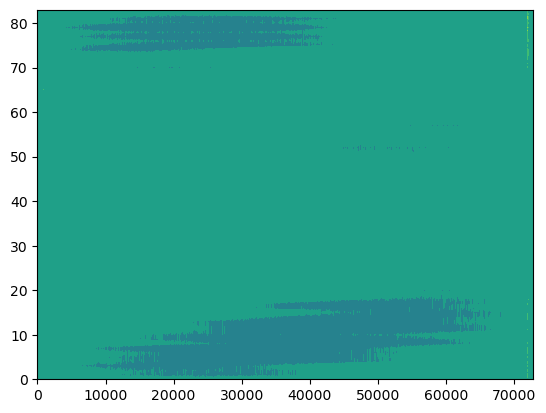

In [72]:
plt.contourf(_)

In [70]:
ds.bpuz.interpolate_na('time',method='linear').sel(z=slice(50,1400)).dropna('time')

<xarray.DataArray 'bpuz' (z: 84, time: 72836)>
array([[ 3.99702581e-04,  2.96128206e-04,  1.90886614e-04, ...,
        -2.34586398e-07, -2.40309232e-07, -2.44268653e-07],
       [-1.70682808e-03, -1.70997095e-03, -1.70366716e-03, ...,
        -3.85133157e-07, -3.89556903e-07, -3.91377169e-07],
       [-2.22376559e-03, -2.20304126e-03, -2.16982955e-03, ...,
        -1.66839861e-07, -1.65623011e-07, -1.63465676e-07],
       ...,
       [ 8.15054136e-05,  6.29406174e-05,  4.39349018e-05, ...,
         2.07046997e-07,  2.03406357e-07,  1.98745193e-07],
       [ 2.03095346e-05,  1.92375056e-05,  1.78797074e-05, ...,
        -1.92431656e-07, -1.97315255e-07, -2.00752401e-07],
       [-2.73687611e-04, -3.16717090e-04, -3.58757344e-04, ...,
        -2.95640984e-07, -2.94371838e-07, -2.91369145e-07]])
Coordinates:
  * time     (time) datetime64[ns] 2019-05-18T14:20:00 ... 2020-10-05T09:30:00
  * z        (z) int64 64 80 96 112 128 144 ... 1312 1328 1344 1360 1376 1392
    lat      float64 ...
    lon      float64 ...